# Import relevant packages

In [1]:
#Pytorch
import torch
import torch.nn as nn
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision.transforms import ToTensor
from torchsummary import summary

#Sci-kit learn
import sklearn.model_selection

#Numpy
import numpy as np

#Matplotlib
import matplotlib.pyplot as plt

#Dataset
from mlxtend.data import mnist_data



In [2]:
random_seed = 1
torch.backends.cudnn.enabled = False
torch.manual_seed(random_seed)

# Download training data from open datasets




In [3]:
# Download training data from open datasets.
training_data = datasets.MNIST(
    root="data",
    train=True,
    download=True,
    transform=ToTensor(),
)

# Download test data from open datasets.
test_data = datasets.MNIST(
    root="data",
    train=False,
    download=True,
    transform=ToTensor(),
)

# Check some of the properties of the data set

In [4]:
classes = training_data.classes
print(classes)

num_training_samples = len(training_data)
print(f"Number of samples in the training data: {num_training_samples}")

num_test_samples = len(test_data)
print(f"Number of samples in the test data: {num_test_samples}")


['0 - zero', '1 - one', '2 - two', '3 - three', '4 - four', '5 - five', '6 - six', '7 - seven', '8 - eight', '9 - nine']
Number of samples in the training data: 60000
Number of samples in the test data: 10000


# Setting up the data sets for training and testing

Shape of X [N, C, H, W]: torch.Size([64, 1, 28, 28])
Shape of y: torch.Size([64]) torch.int64


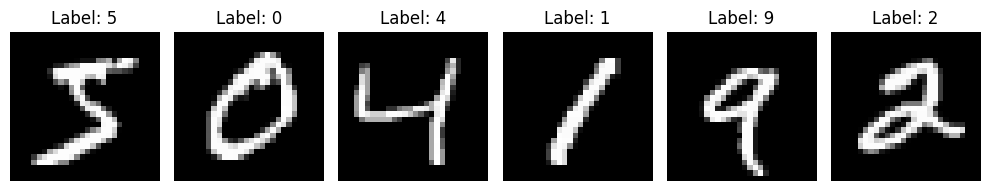

In [5]:
batch_size = 64 # we will talk about it later

# Create data loaders.
train_dataloader = DataLoader(training_data, batch_size=batch_size)
test_dataloader = DataLoader(test_data, batch_size=batch_size)

for X, y in train_dataloader:
    print(f"Shape of X [N, C, H, W]: {X.shape}")
    print(f"Shape of y: {y.shape} {y.dtype}")

    fig, axes = plt.subplots(1, 6, figsize=(10, 10))
    axes = axes.flatten()

    for i in range(6):
        img = X[i].squeeze().numpy()
        axes[i].imshow(img, cmap="gray")
        axes[i].set_title(f"Label: {y[i]}")
        axes[i].axis('off')

    plt.tight_layout()
    plt.show()

    break

# Defining a simple MLP network architecture

| Layer type   | size    | Output channels  | Stride |
|--------------|---------|------------------|--------|
| fully connected   |      | 784               |       |
| ReLU   |      | 784               |       |
| fully connected   |      | 512               |       |
| ReLU   |      | 512               |       |
| fully connected   |      | 10               |       |



In [6]:
# Get cpu, gpu or mps device for training.
device = (
    "cuda" if torch.cuda.is_available()
     else "cpu"
)
print(f"Using {device} device")

# Define model
class NeuralNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        self.flatten = nn.Flatten()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(28*28, 512),
            nn.ReLU(inplace=True),
            nn.Linear(512, 512),
            nn.ReLU(inplace=True),
            nn.Linear(512, 10)
        )

    def forward(self, x):
        x = self.flatten(x)
        logits = self.linear_relu_stack(x)
        return logits

model = NeuralNetwork().to(device)
print(model)


Using cuda device
NeuralNetwork(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=784, out_features=512, bias=True)
    (1): ReLU(inplace=True)
    (2): Linear(in_features=512, out_features=512, bias=True)
    (3): ReLU(inplace=True)
    (4): Linear(in_features=512, out_features=10, bias=True)
  )
)


# We can also see the model parameters and the size at each layer of the model
This is done by using the pytorchsummary package https://github.com/sksq96/pytorch-summary

In [7]:
summary(model, input_size=(1, 28, 28), device=device)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
           Flatten-1                  [-1, 784]               0
            Linear-2                  [-1, 512]         401,920
              ReLU-3                  [-1, 512]               0
            Linear-4                  [-1, 512]         262,656
              ReLU-5                  [-1, 512]               0
            Linear-6                   [-1, 10]           5,130
Total params: 669,706
Trainable params: 669,706
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.02
Params size (MB): 2.55
Estimated Total Size (MB): 2.58
----------------------------------------------------------------


## Defining a loss-function

Let’s use a Classification Cross-Entropy loss SGD.
Our labels are one-hot encoded, which means that for each image, we have a target vector with 10 entries (one for each class).
This target vector contains only zeros except for the entry of the class to which the image belongs.

\begin{equation}
H(y,\hat y) = -\sum_j y_j \cdot log(\hat y_j)
\end{equation}

$j \in \{1, 2, \dots, n_{\text{classes}}\}$ and $\hat{y}_j = \begin{cases}
    1 & \text{if } j = \text{true class}, \\
    0 & \text{otherwise}
\end{cases}$

Explanation: Let’s assume a simple case where we have three classes. The true label vector y for a given sample is [0, 0, 1] (indicating class 3 is the correct label), and the model outputs a probability distribution p = [0.1, 0.3, 0.6].

\begin{equation}
\text{Loss} = -[0 \times \log(0.1) + 0 \times \log(0.3) + 1 \times \log(0.6)] = -\log(0.6) = 0.51
\end{equation}



In [9]:
def train(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    model.train()
    total_loss, correct = 0, 0  # Track the total loss for the epoch

    for batch, (X, y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)

        # Compute prediction error
        pred = model(X)
        loss = loss_fn(pred, y)
        total_loss += loss.item()  # Accumulate loss

        # Backpropagation
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        # Calculate accuracy
        correct += (pred.argmax(1) == y).type(torch.float).sum().item()

        if batch % 100 == 0:
            loss, current = loss.item(), (batch + 1) * len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")
    avg_loss = total_loss / len(dataloader)  # Calculate average loss for the epoch
    avg_accuracy = correct / size

    train_losses.append(avg_loss)  # Store the average loss for the epoch
    train_accuracies.append(avg_accuracy) # Store the average accuracy for the epoch

    print(f"Train loss: {avg_loss:>7f}, Accuracy: {(100*avg_accuracy):>0.1f}%")


In [10]:
def test(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    model.eval()
    test_loss, correct = 0, 0
    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()
    test_loss /= num_batches
    correct /= size
    test_losses.append(test_loss)  # Store the test loss for the epoch
    test_accuracies.append(correct)

    print(f"Test Error: \n Avg loss: {test_loss:>8f}, Accuracy: {(100*correct):>0.1f}% \n")


In [20]:
train_losses = []
test_losses = []
train_accuracies = []
test_accuracies = []

epochs = 5

model = NeuralNetwork().to(device)

loss_fn = nn.CrossEntropyLoss()

optimizer = torch.optim.SGD(model.parameters(), lr=1e-3) # Let's use stocastic gradient descent (We will talk about it in the coming weeks)


for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train(train_dataloader, model, loss_fn, optimizer)
    test(test_dataloader, model, loss_fn)
print("Done!")


Epoch 1
-------------------------------
loss: 2.294176  [   64/60000]
loss: 2.290126  [ 6464/60000]
loss: 2.310973  [12864/60000]
loss: 2.285190  [19264/60000]
loss: 2.296711  [25664/60000]
loss: 2.290039  [32064/60000]
loss: 2.271708  [38464/60000]
loss: 2.280930  [44864/60000]
loss: 2.263357  [51264/60000]
loss: 2.268822  [57664/60000]
Train loss: 2.283624, Accuracy: 22.7%
Test Error: 
 Avg loss: 2.259125, Accuracy: 32.6% 

Epoch 2
-------------------------------
loss: 2.246928  [   64/60000]
loss: 2.241829  [ 6464/60000]
loss: 2.268723  [12864/60000]
loss: 2.224913  [19264/60000]
loss: 2.244639  [25664/60000]
loss: 2.236887  [32064/60000]
loss: 2.207916  [38464/60000]
loss: 2.235794  [44864/60000]
loss: 2.200858  [51264/60000]
loss: 2.202530  [57664/60000]
Train loss: 2.229673, Accuracy: 40.7%
Test Error: 
 Avg loss: 2.192997, Accuracy: 48.8% 

Epoch 3
-------------------------------
loss: 2.181400  [   64/60000]
loss: 2.171682  [ 6464/60000]
loss: 2.207730  [12864/60000]
loss: 2.13

# Check the performance of the network through train and test loss and accuracy curves

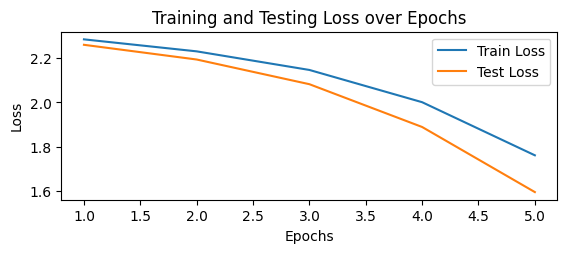

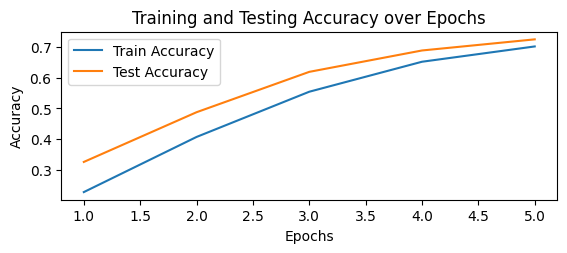

In [21]:
plt.subplot(2,1,1)
plt.plot(range(1, epochs+1), train_losses, label="Train Loss")
plt.plot(range(1, epochs+1), test_losses, label="Test Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training and Testing Loss over Epochs")
plt.legend()
plt.show()

plt.subplot(2,1,2)
plt.plot(range(1, epochs+1), train_accuracies, label="Train Accuracy")
plt.plot(range(1, epochs+1), test_accuracies, label="Test Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Training and Testing Accuracy over Epochs")
plt.legend()
plt.show()


# Check result for one image

Predicted: "7 - seven", Actual: "7 - seven"


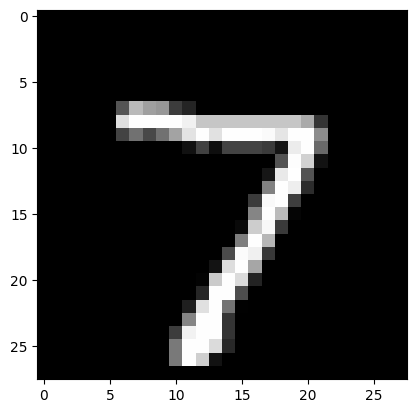

In [23]:
model.eval()
idx = 0
x, y = test_data[idx][0], test_data[idx][1]
plt.imshow(x.permute(1,2,0), cmap = 'gray')
with torch.no_grad():
    x = x.to(device)
    pred = model(x)
    predicted, actual = classes[pred[0].argmax(0)], classes[y]
    print(f'Predicted: "{predicted}", Actual: "{actual}"')
